#### My attempt at a Hopper's puzzle dataset

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from math import sin, cos, sqrt, atan2, radians

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12,6)

In [2]:
df = pd.read_csv("/Users/aeshaanwahlang/Desktop/puzzle.csv", names=["A", "B"])

In [4]:
df.describe()

,A,B
count,1024.000000,1024.000000
mean,0.504729,-0.388165
std,0.355107,1.499346
min,-0.925070,-2.837888
25%,0.389721,-1.559228
50%,0.591392,-1.129903
75%,0.746583,0.578621
max,1.195399,3.096964


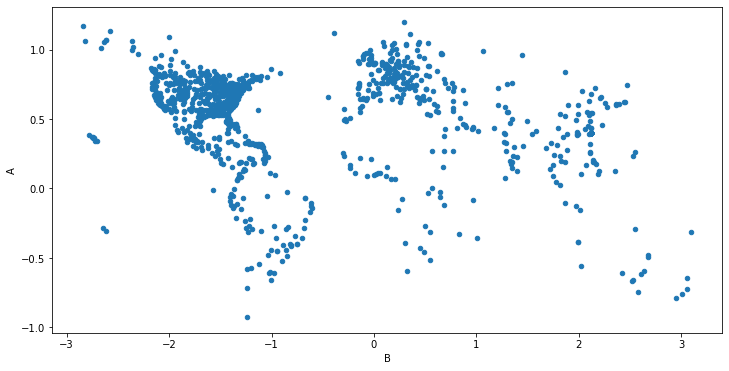

In [116]:
df.plot(kind='scatter', x="B", y="A")

#### A world map? possibly locations?

However before we explore this, I'd like to explore the frequency distributions of the variables to see it that can give us other clues

Text(0.5, 1.0, 'B')

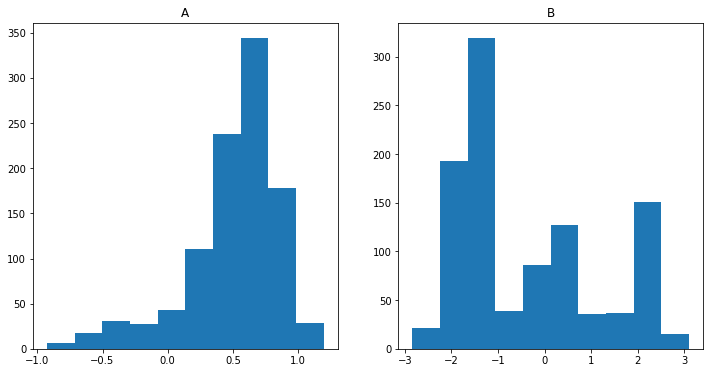

In [152]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(df['A'].values, bins = 10)
ax1.set_title("A")
ax2.hist(df['B'].values, bins = 10)
ax2.set_title("B")

Variable A's distribution appears to be skewed negatively and neither seem normally distributed.

A possible way of trying to identify their distributions would be to try to fit them to different kinds of distributions and use the Kolmogorov-Smirnov test to find the distribution with the highest p value.
We can do this fairly easily in scipy

In [159]:
def get_best_distribution(data):
    #list of all distibutions available in scipy.stats 
    dist_names = [ 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy'] 
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
#         print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    sorted_dist = sorted(dist_results, key=lambda tup: tup[1], reverse=True)
    for i in range(10):
        print(sorted_dist[i])
        
    return None

get_best_distribution(df['A'].values)
print("-----")
get_best_distribution(df['B'].values)

('exponweib', 0.010087773216289436)
('gengamma', 0.009743850968402157)
('gumbel_l', 0.008829446118779031)
('frechet_r', 0.005792999505032904)
('gompertz', 0.0052499250002145375)
('burr', 0.0016406133465460512)
('genlogistic', 0.00026322047126496194)
('dgamma', 0.00026176392721692404)
('exponpow', 0.0002551964763229345)
('dweibull', 0.00017532476668665633)
-----
('mielke', 4.7484987650142295e-12)
('burr', 2.769605984569858e-12)
('fisk', 1.4962370838660268e-12)
('johnsonsu', 6.724527066856961e-13)
('dweibull', 3.2259892102889227e-13)
('invweibull', 5.0194425196141155e-14)
('genextreme', 5.018372404687583e-14)
('dgamma', 3.136927641442634e-14)
('f', 3.1188589513210217e-14)
('invgamma', 2.2593401216183773e-14)


Our test reveals that A's frequency distribution is most similar to that of an exponentiated Weibull continuous random variable, and that of B's a Mielke’s Beta-Kappa continuous random variable.

Non of these stand out, I think I'm over thinking this.

---

We're now going to check if either of the variables show some sort of trend. To gain a simple visual intuition of this were going to plot a rolling average of the variable to see if some sort of trend is hinted.

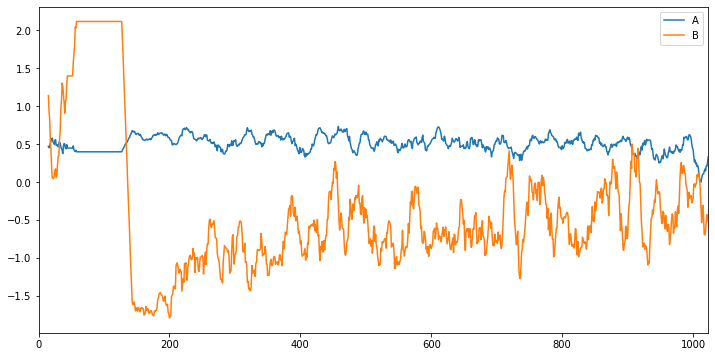

In [162]:
df.loc[:, ["A", "B"]].rolling(16).mean().plot()

No obvious trend is hinted. I don't think we'll find more clues on this train of thought. We're going to go back to the world map and the possibility of locations

---

It appears that the values might be in radians, we begin by converting them to decimal degree for regular latitude and longitude formats

In [12]:
df['lat'] = df['A']*180/math.pi
df['long'] = df['B']*180/math.pi

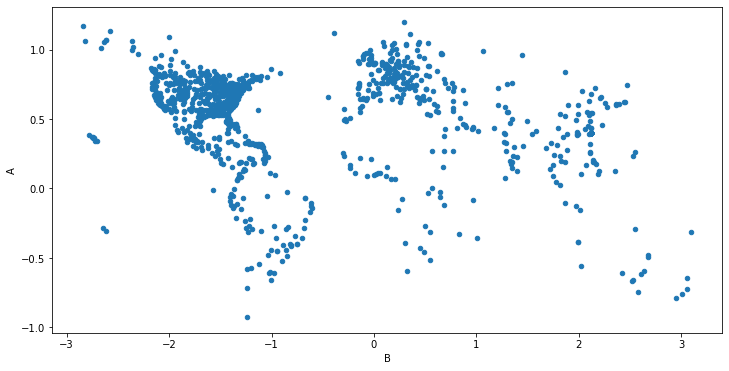

In [163]:
df.plot(kind='scatter', x="B", y="A")

I was going to overlay a world map on the above plot, but I ran into a conda-forge eroor with mpl_toolkits.basemap and Im not keen of working that out.

After looking up a small random sample of coordinates in the dataset, they appear to be locations of Airports. This makes sense considering that Hopper is a tavel company.

I found this dataset of airports with their coordinates:
https://www.partow.net/miscellaneous/airportdatabase/index.html#GlobalAirportDatabaseLicense

Its under the MIT license and were going to use it to match our dataset locations

In [59]:
cols = ['ICAO code', 'IATA code', 'Name', 'City', 'Country', 'lat degrees', 'lat minutes', 'lat seconds', 'lat direction', 'long degrees', 'long minutes', 'long seconds', 'long direction',
       'altitude', 'lat dec', 'long dec']

airports = pd.read_csv("/Users/aeshaanwahlang/Documents/Airports_database/GlobalAirportDatabase/GlobalAirportDatabase.txt", sep=":", names=cols)

Simple matching the coordinates results in only around 45 matches, instead we are going to use the haversine formula to find the distance between a pair of locations and then find the closest airport from our dataset.

In [63]:
# haversine distance
def find_distance(lat1, long1, lat2, long2):
    # approximate radius of earth in km
    R = 6373.0
    lat1 = radians(lat1)
    long1 = radians(long1)
    lat2 = radians(lat2)
    long2 = radians(long2)

    dlong = long2 - long1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlong / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def find_closest_airport(lat, long):
    distances = []
    for idx, row in airports.iterrows():
        temp = {'id':idx, 'name':row['Name'], 'city':row['City'], 'country':row['Country'],
                 'altitude':row['altitude'], 'distance': find_distance(lat, long, row['lat dec'], row['long dec'])}
        distances.append(temp)
    
    distances = sorted(distances, key=lambda k: k['distance'])
    return distances[0]

In [ ]:
# not an efficient way, but it'll do for now
for idx, row in df.iterrows():
    airport = find_closest_airport(row['lat'], row['long'])
    df.at[idx, 'airport'] = airport['name']
    df.at[idx, 'city'] = airport['city']
    df.at[idx, 'country'] = airport['country']
    df.at[idx, 'altitude'] = airport['altitude']
    
    if idx % 50 == 0: print(idx)
df.to_csv("hopper_airports.csv", index=False)

In [125]:
df.describe()

,A,B,lat,long,altitude
count,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000
mean,0.504729,-0.388165,28.918827,-22.240203,296.805664
std,0.355107,1.499346,20.346147,85.906197,519.960421
min,-0.925070,-2.837888,-53.002600,-162.599000,-4.000000
25%,0.389721,-1.559228,22.329375,-89.337200,23.000000
50%,0.591392,-1.129903,33.884250,-64.738650,67.000000
75%,0.746583,0.578621,42.776075,33.152550,314.500000
max,1.195399,3.096964,68.491300,177.443000,4058.000000


Now to run some basic analysis on the new labelled dataset

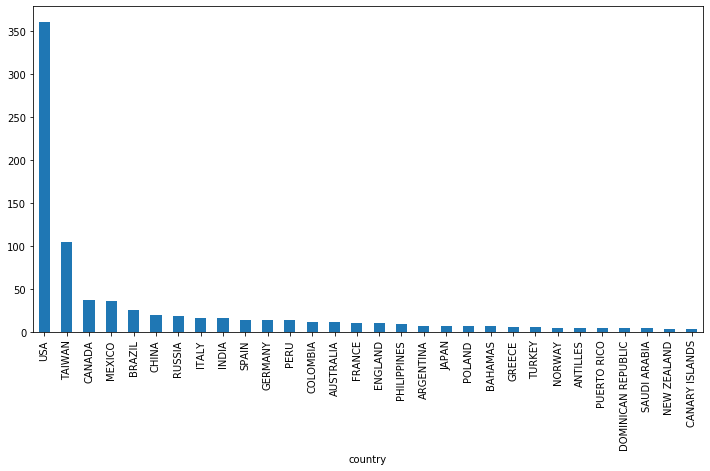

In [141]:
plot_data1 = df.groupby('country').count()['A'].sort_values(ascending=False)
plot_data1[:30].plot(kind='bar')

It appears that the United states has the most airport mentions here

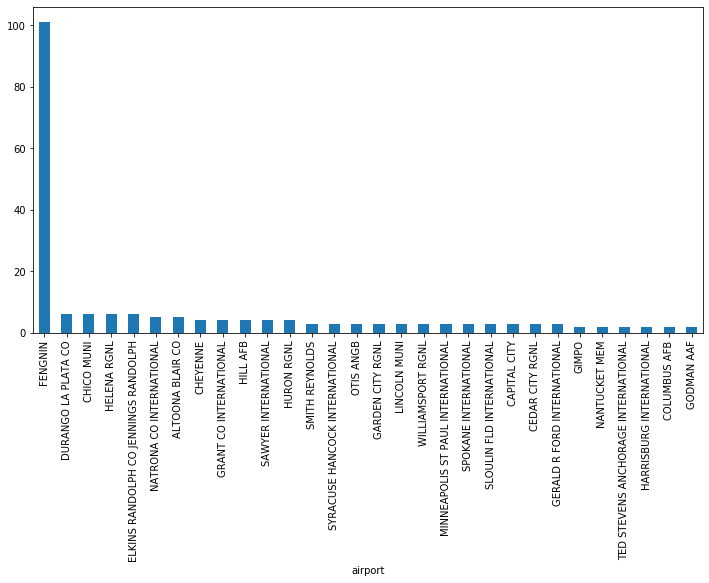

In [131]:
plot_data2 = df.groupby('airport').count()['A'].sort_values(ascending=False)
plot_data2[:30].plot(kind='bar')

With regards to airports themselves, Taiwans's Taitung airport (Fengnin) in our dataset has the most occurances

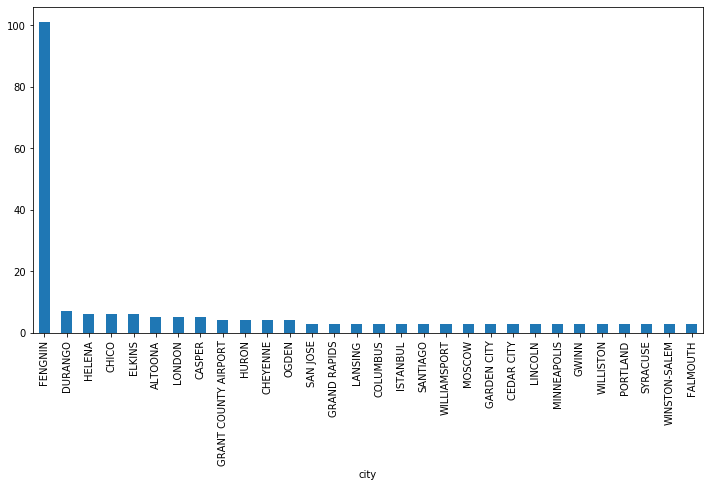

In [133]:
plot_data3 = df.groupby('city').count()['A'].sort_values(ascending=False)
plot_data3[:30].plot(kind='bar')

Taiwan's Fengnin also has the most mentions as a city

In [148]:
alt_df = df[df['altitude']>100]
alt_df.groupby('airport').count()["A"].sort_values(ascending=False).head(10)

airport
DURANGO LA PLATA CO                     6
HELENA RGNL                             6
ELKINS RANDOLPH CO JENNINGS RANDOLPH    6
NATRONA CO INTERNATIONAL                5
ALTOONA BLAIR CO                        5
GRANT CO INTERNATIONAL                  4
CHEYENNE                                4
SAWYER INTERNATIONAL                    4
HILL AFB                                4
HURON RGNL                              4
Name: A, dtype: int64

Our dataset also shows that most of the popular airports are at a lower altitude. The above list shows the airports with the most mentions that are above 100 meters above sea level.